# Establishing steady state and then getting energy balances to function

In [3]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate
import CoolProp
import CoolProp.CoolProp as CP
import pandas as pd

In [4]:
def vle_data(xi):
    
    x_data = [0, 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943, 1]
    y_data = [0, 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943, 1]
    T_data = [100,95.5,89,86.7,85.3,84.1,82.7,82.3,81.5,80.7,79.8,79.7,79.3,
             78.74,78.41,78.15,78.30]
    x = np.interp(xi,x_data, y_data)
    T = np.interp(xi,x_data,T_data)
    return x,T

In [25]:
def feed_vector(plates,feedplate,feed):
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    feed_vec1 = np.zeros(plates)
    feed_vec2 = np.zeros(plates)
    flow_vec_top = np.zeros(plates)
    flow_vec_bot = np.zeros(plates)
    
    flow_vec_top[0:feedplate] = L1
    flow_vec_top[feedplate:] = L2
    
    flow_vec_bot[0:feedplate-1] = L1
    flow_vec_bot[feedplate-1:] = L2
    
    feed_vec1[feedplate-1] = feed
    feed_vec2[0] = R
    feed_vec2[-1] = BU
    
    return np.asarray([flow_vec_top,flow_vec_bot,feed_vec1,feed_vec2])

In [6]:
def comp_vector(xi,yi):
    
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    xi1 = np.copy(xi)
    xi1 = np.roll(xi1, 1)
    xi1[0] = 0
    
    xi2 = np.copy(xi)
    xi2[-1] = 0
    
    yi1 = np.copy(yi)
    yi1 = np.roll(yi1, -1)
    yi1[-1] = 0
    
    yi2 = np.copy(yi)
    yi2[0] = 0
    
    
    return np.asarray([xi1,xi2]),np.asarray([yi1,yi2])

In [7]:
def holdup_vector(plates, m_cond,m_tray,m_rebl):
    holdup_vec = np.zeros(plates)
    
    holdup_vec[0] = m_cond
    holdup_vec[-1] = m_rebl
    holdup_vec[1:plates-1] = m_tray
    
    return holdup_vec

In [26]:
def mass_DE(t, x):
    
    xi = np.asarray(x)
    yi,_ = vle_data(xi)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates, m_cond,m_tray,m_rebl)
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
                     
    return dxdt

## Establishing an initial steady state vector 

In [27]:
init = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

plates = 12
feedplate = 4

F = 1 # Feed on plate 3
D =0.5
xF = 0.5 # mole fraction in feed
R_r = 0.6 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler

In [28]:
tspan = (0,50)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

In [29]:
x = initial_run.y

[0.71332218 0.62858247 0.56756165 0.51559062 0.51558868 0.51557352
 0.51550557 0.51508155 0.51288654 0.50231758 0.4596435  0.28665376]


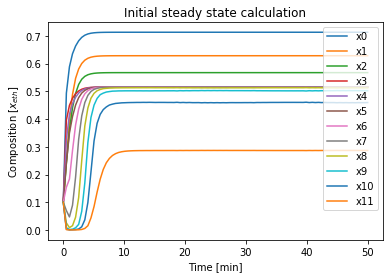

In [30]:
plt.figure(1)
plt.title("Initial steady state calculation")

for i in range(len(initial_run.y)) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

plt.savefig("Basic_distillation_column_V3.svg")
print(x[:,-1])

In [229]:
x_ss = [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
        0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]
y_ss,T_ss = vle_data(x_ss)
steady_state = pd.DataFrame({'x_ss':x_ss, 'y_ss':y_ss, 'T_ss':T_ss})
steady_state

,x_ss,y_ss,T_ss
0,0.713322,0.760954,78.567682
1,0.628582,0.713322,78.999183
2,0.567562,0.681545,79.342235
3,0.515591,0.658662,79.735373
4,0.515589,0.658661,79.735389
5,0.515574,0.658657,79.735517
6,0.515506,0.658637,79.736088
7,0.515082,0.658512,79.739651
8,0.512887,0.657867,79.758096
9,0.502318,0.654185,79.845100


## Adding energy balance functions 

In [230]:
def H(xi,yi,Ti):
    Hi_L = []
    Hi_V = []
    Ti = np.asarray(Ti)
    
    for i in range(len(xi)):
        y = round(yi[i],5)
        Hi_L.append(CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
        Hi_V.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{y}]&Water[{1-y}]'))
        
    Hi_L = np.asarray(Hi_L)
    Hi_V = np.asarray(Hi_V)
    
    Hi_L1 = np.copy(Hi_L)
    Hi_L1 = np.roll(Hi_L1, 1)
    Hi_L1[0] = 0
    
    Hi_L2 = np.copy(Hi_L)
    Hi_L2[-1] = 0
    
    Hi_V1 = np.copy(Hi_V)
    Hi_V1 = np.roll(Hi_V1, -1)
    Hi_V1[-1] = 0
    
    Hi_V2 = np.copy(Hi_V)
    Hi_V2[0] = 0
    
    Hi_F = np.zeros(plates)
    Hi_F[feedplate-1] = CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xF}]&Water[{1-xF}]')
    
    return [Hi_L,Hi_L1,Hi_L2,Hi_V,Hi_V1,Hi_V2,Hi_F]

In [278]:
def cond_duty(M,Tout):
    cp_w = CP.PropsSI('CPMASS','P',101325,'T',298,'Water')
    
    Qcond = -M*cp_w*(Tout - 25)
    
    return Qcond

In [279]:
def rebl_duty(M,Tout):
    cp_w = CP.PropsSI('CPMASS','P',500000,'T',400,'Water')
    
    Qcond = -M*cp_w*(Tout - 126)
    
    return Qcond
rebl_duty(1,100)

110625.57369639185

In [280]:
def duty(plates,feedplate,Qcond,Qrebl):
    duty_vector = np.zeros(plates)
    duty_vector[0] = Qcond

    duty_vector[-1] = Qrebl
    
    return duty_vector

In [281]:
def Cp(xi):
    CPi = []
    
    for i in range(len(xi)):
        CPi.append(CP.PropsSI('CPMOLAR','Q',0,'P',101325,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
    return np.asarray(CPi)

## Vectorized model with energy balance

In [282]:
def mass_DE(t,var):
    
    # values for compositon and temperature is fed as a 1-D array and reshaped
    x,T = np.reshape(var,(2,-1))
    
    xi = np.asarray(x)
    Ti = np.asarray(T)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    yi,T_fake = vle_data(xi) # change to vle_data() for interpolation of vapour liquid equilibrium
    
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4 # change this to vary which plate is fed on
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl)

    # component mass balance 
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
    
    
    HL,HL1, HL2, HV, HV1, HV2, Hi_F = H(xi,yi)
    CPi = Cp(xi)
    
    duty_vector = duty(plates,feedplate,cond_duty(0.03,28),rebl_duty(0.8,100))

#      Energy balance with coolprops  
    
    dTdt = 1/(holdup_vec*CPi)*( V*(HV1 - HV2) + flow1*HL1 - flow2*HL2 + feed1*HL - feed2*HL + F*Hi_F + duty_vector ) 
    
#     dTdt = np.zeros(len(Ti))  # Unhash this to just use mass balance

    didt = np.concatenate([dxdt, dTdt])

    return didt

## Use steady state values as initial condition

In [283]:
init = np.concatenate([x_ss,T_ss+273])
init

array([7.13322180e-01, 6.28582470e-01, 5.67561650e-01, 5.15590620e-01,
       5.15588680e-01, 5.15573520e-01, 5.15505570e-01, 5.15081550e-01,
       5.12886540e-01, 5.02317580e-01, 4.59643500e-01, 2.86653760e-01,
       6.24567682e+02, 6.24999183e+02, 6.25342235e+02, 6.25735373e+02,
       6.25735389e+02, 6.25735517e+02, 6.25736088e+02, 6.25739651e+02,
       6.25758096e+02, 6.25845100e+02, 6.26189864e+02, 6.27988977e+02])

In [284]:
mass_DE(0,init)

array([-2.01745879e-08,  3.09174580e-08, -1.52551223e-07,  1.16264706e-06,
       -5.22529412e-06,  1.85988235e-05, -5.71720588e-05,  1.73765294e-04,
       -4.58664101e-04,  9.71333860e-04, -1.37607317e-03,  3.52249230e-04,
        1.64615484e+03,  2.48297790e+00,  1.97445075e+00,  1.39881576e+02,
       -7.11521580e-04,  7.57769565e-04,  1.61475051e-02,  4.67344010e-02,
        3.60053044e-01,  1.53480733e+00,  7.52473436e+00,  1.18868969e+03])

In [ ]:
tspan = (0,15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

In [ ]:
plt.figure(1)
plt.title("Initial steady state calculation")

plt.figure(1)
for i in range(0,12) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))

plt.figure(2)
for i in range(12,24) :
    plt.plot(t,initial_run.y[i]-273, label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Enthalpy [$kJ/time$]")
plt.legend(loc = "upper right")

print(initial_run.y[:,0])

## Now instead of trying to "balance" the temperatures lets just try the energy balance as it normally is 

In [248]:
def H(xi,yi):
    Hi_L = []
    Hi_V = []
    
    for i in range(len(xi)):
        y = round(yi[i],5)
        Hi_L.append(CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
        Hi_V.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{y}]&Water[{1-y}]'))
        
    Hi_L = np.asarray(Hi_L)
    Hi_V = np.asarray(Hi_V)
    
    Hi_L1 = np.copy(Hi_L)
    Hi_L1 = np.roll(Hi_L1, 1)
    Hi_L1[0] = 0
    
    Hi_L2 = np.copy(Hi_L)
    Hi_L2[-1] = 0
    
    Hi_V1 = np.copy(Hi_V)
    Hi_V1 = np.roll(Hi_V1, -1)
    Hi_V1[-1] = 0
    
    Hi_V2 = np.copy(Hi_V)
    Hi_V2[0] = 0
    
    Hi_F = np.zeros(plates)
    Hi_F[feedplate-1] = CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xF}]&Water[{1-xF}]')
    
    return [Hi_L,Hi_L1,Hi_L2,Hi_V,Hi_V1,Hi_V2,Hi_F]

In [249]:
def mass_DE(t,var):
    
    # values for compositon and temperature is fed as a 1-D array and reshaped
    x,Hi = np.reshape(var,(2,-1))
    
    xi = np.asarray(x)
    Hi = np.asarray(Hi)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    yi,T_fake = vle_data(xi) # change to vle_data() for interpolation of vapour liquid equilibrium
    
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4 # change this to vary which plate is fed on
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl)

    # component mass balance 
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
    
    
    HL,HL1, HL2, HV, HV1, HV2, Hi_F = H(xi,yi)
    CPi = Cp(xi)
    
    duty_vector = duty(plates,feedplate,cond_duty(0.03,28),rebl_duty(0.8,100))
#     duty_vector = duty(plates,feedplate,0,0)

#      Energy balance with coolprops  
    
#   Instead of doing the balance for the temperature on each plate

    dHdt = 1/(holdup_vec)*( V*(HV1 - HV2) + flow1*HL1 - flow2*HL2 + feed1*HL - feed2*HL + F*Hi_F + duty_vector ) 
#     print(dHdt)

    
#     dTdt = np.zeros(len(Ti))  # Unhash this to just use mass balance
    didt = np.concatenate([dxdt, dHdt])

    return didt

## Get the initial conditions of the enthalpy from the steady state conditions

In [250]:
x_ss = [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
        0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]
Hi_ss = []
y_ss,T_ss = vle_data(x_ss)
T_ss = T_ss + 273

for i in range(len(x_ss)):
    Hi_ss.append(CP.PropsSI('HMOLAR','T',T_ss[i],'Q',0,f'Ethanol[{x_ss[i]}]&Water[{1-x_ss[i]}]'))
Hi_ss

[1958.8396079181528,
 2530.904109253819,
 2936.312518569341,
 3289.0474099211606,
 3289.060692063979,
 3289.1644842631267,
 3289.6296959407387,
 3292.53252609838,
 3307.554728574584,
 3379.559154925032,
 3667.382086904755,
 4807.787487046456]

In [251]:
init = np.concatenate([x_ss,Hi_ss])

In [252]:
mass_DE(0,init)

array([-2.01745879e-08,  3.09174580e-08, -1.52551223e-07,  1.16264706e-06,
       -5.22529412e-06,  1.85988235e-05, -5.71720588e-05,  1.73765294e-04,
       -4.58664101e-04,  9.71333860e-04, -1.37607317e-03,  3.52249230e-04,
        2.08655209e+05,  3.06356381e+02,  2.38299968e+02,  1.65379494e+04,
       -8.41218607e-02,  8.95891119e-02,  1.90902363e+00,  5.52416204e+00,
        4.25207816e+01,  1.80454749e+02,  8.68450982e+02, -1.68073976e+05])

In [253]:
tspan = (0,15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

[7.13322180e-01 6.28582470e-01 5.67561650e-01 5.15590620e-01
 5.15588680e-01 5.15573520e-01 5.15505570e-01 5.15081550e-01
 5.12886540e-01 5.02317580e-01 4.59643500e-01 2.86653760e-01
 1.95883961e+03 2.53090411e+03 2.93631252e+03 3.28904741e+03
 3.28906069e+03 3.28916448e+03 3.28962970e+03 3.29253253e+03
 3.30755473e+03 3.37955915e+03 3.66738209e+03 4.80778749e+03]


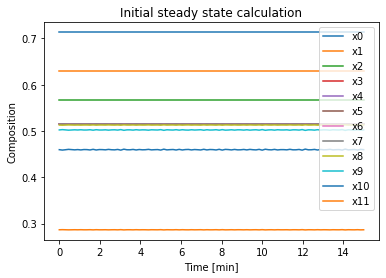

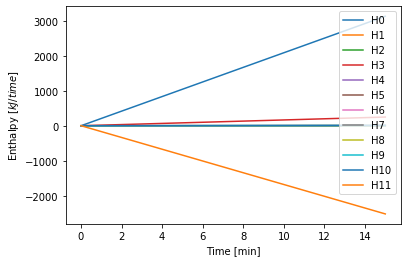

In [262]:
plt.figure(1)
plt.title("Initial steady state calculation")

plt.figure(1)
for i in range(0,12) :
    plt.plot(t,initial_run.y[i], label= f"x{i}")
    
plt.xlabel("Time [min]")
plt.ylabel("Composition")
plt.legend(loc = "upper right")

    
plt.figure(2)
for i in range(12,24) :
    plt.plot(t,initial_run.y[i]/1000, label=f"H{i-12}")
    
plt.xlabel("Time [min]")
plt.ylabel("Enthalpy [$kJ/time$]")
plt.legend(loc = "upper right")

print(initial_run.y[:,0])